# Job Salary Prediction
_Predict the salary of any UK job ad based on its contents_

### Job Data

- **Id**: Identificador para cada job.

- **Title**: Texto livre com o titulo ou resumo da vaga.

- **FullDescription**: Descrição da vaga sem qualquer informação salarial.

- **LocationRaw**: Localização da vaga em texto livre.

- **LocationNormalized**: Localização aproximada a partir da convesao do texto livre.

- **ContractType**: full_time ou part_time.

- **ContractTime**: permanent or contract.

- **Company**: Nome da empresa.

- **Category**: Qual das 30 categorias de trabalho padrão esse anúncio se encaixa, inferida de uma maneira muito confusa com base na origem da origem do anúncio. Sabemos que há muito barulho e erro nesse campo.

- **SalaryRaw**: Descrição salarial em texto livre.

- **SalaryNormalised**: Salario bruto anual. Valor que estamos tentando prever.

- **SourceName**: Nome do site ou anunciante da vaga.

### Location Tree

Este é um conjunto de dados suplementares que descreve o relacionamento hierárquico entre os diferentes locais normalizados mostrados nos dados do trabalho. É provável que existam relações significativas entre os salários dos empregos em uma área geográfica semelhante, por exemplo, os salários médios em Londres e no Sudeste são mais altos do que no resto do Reino Unido.

### Saida


    Id,SalaryNormalized
    13656201,36205
    14663195,74570
    16530664,31910.50
    ... 
    
### Sizes

- Train:
    - 421M 
    - 244768 entries
- Test: 
    - 206M
    - 122463 entries
    
### Problema
- Regressão Linear
     - Determinar os salarios a partir de anúncios
     
### Métricas
- Mean Squared Error – MSE
- Mean Absolute Error – MAE

## Imports

In [36]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

## Dataset

In [2]:
!ls -lha

total 811M
drwxr-xr-x 4 unknown unknown 4,0K jun 24 16:18 .
drwxr-xr-x 7 unknown unknown 4,0K jun 19 01:34 ..
drwxr-xr-x 8 unknown unknown 4,0K jun 19 01:37 .git
-rw-r--r-- 1 unknown unknown   19 jun 17 18:09 .gitignore
drwxr-xr-x 2 unknown unknown 4,0K jun 23 23:38 .ipynb_checkpoints
-rw-r--r-- 1 unknown unknown 108K jun 24 16:18 Job Salary Prediction.ipynb
-rw-r--r-- 1 unknown unknown 111K jun 24 01:47 Job_Salary_Prediction__v1.ipynb
-rw-r--r-- 1 unknown unknown 108K jun 24 04:30 Job_Salary_Prediction__v2.ipynb
-rw-r--r-- 1 unknown unknown 161K jun 18 02:07 List_12__Clustering.ipynb
-rw-r--r-- 1 unknown unknown 376K jun 19 01:31 List_13__Clusterization_Hierarchical.ipynb
-rw-r--r-- 1 unknown unknown  216 jun 18 01:16 README.md
-rw-r--r-- 1 unknown unknown 206M fev 21  2013 Test_rev1.csv
-rw-r--r-- 1 unknown unknown  62M jun 23 23:55 Test_rev1.zip
-rw-r--r-- 1 unknown unknown 421M fev 21  2013 Train_rev1.csv
-rw-r--r-- 1 unknown unknown 123M jun 23 23:49 Train_rev1.zip


In [199]:
df_job_data = pd.read_csv('Train_rev1.csv')

In [200]:
df_test_rev1 = pd.read_csv('Test_rev1.csv')

## Informações

### Job Data

In [157]:
df_job_data.head(n=2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [6]:
df_job_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
Id                    244768 non-null int64
Title                 244767 non-null object
FullDescription       244768 non-null object
LocationRaw           244768 non-null object
LocationNormalized    244768 non-null object
ContractType          65442 non-null object
ContractTime          180863 non-null object
Company               212338 non-null object
Category              244768 non-null object
SalaryRaw             244768 non-null object
SalaryNormalized      244768 non-null int64
SourceName            244767 non-null object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63273053c8>]],
      dtype=object)

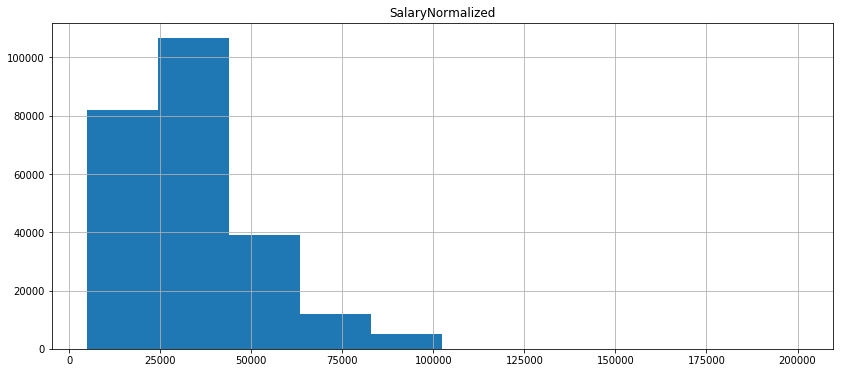

In [14]:
df_job_data.hist(column='SalaryNormalized', figsize=(14,6))

In [29]:
df_job_data.describe()

,Id,SalaryNormalized
count,2.447680e+05,244768.000000
mean,6.970142e+07,34122.577576
std,3.129813e+06,17640.543124
min,1.261263e+07,5000.000000
25%,6.869550e+07,21500.000000
50%,6.993700e+07,30000.000000
75%,7.162606e+07,42500.000000
max,7.270524e+07,200000.000000


### Test

In [9]:
df_test_rev1.head(n=2)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
0,11888454,Business Development Manager,The Company: Our client is a national training...,"Tyne Wear, North East",Newcastle Upon Tyne,NaN,permanent,Asset Appointments,Teaching Jobs,cv-library.co.uk
1,11988350,Internal Account Manager,The Company: Founded in **** our client is a U...,"Tyne and Wear, North East",Newcastle Upon Tyne,NaN,permanent,Asset Appointments,Consultancy Jobs,cv-library.co.uk


In [116]:
df_test_rev1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122463 entries, 0 to 122462
Data columns (total 10 columns):
Id                    122463 non-null int64
Title                 122463 non-null object
FullDescription       122463 non-null object
LocationRaw           122463 non-null object
LocationNormalized    122463 non-null object
ContractType          33013 non-null object
ContractTime          90702 non-null object
Company               106202 non-null object
Category              122463 non-null object
SourceName            122463 non-null object
dtypes: int64(1), object(9)
memory usage: 9.3+ MB


## Pré-processamento

In [201]:
def normalizeTextField(df, field):
    vectorizer = CountVectorizer(max_features=100)
    fields = vectorizer.fit_transform(df[field]).toarray()
    # Generate field names
    fcols = np.vectorize(lambda x: field + str(x))(np.arange(2))
    # Reduz a dimensionalidade para 2 
    pca = PCA(n_components = 2)
    _df = pd.DataFrame(pca.fit_transform(fields), columns=fcols)
    # Concatena o dataframe com o novo
    df = pd.concat([df, _df], join ='inner', axis=1)
    del df[field]
    return df

### SalaryRaw

In [202]:
del df_job_data['SalaryRaw']

### Remove ContractType

Grande quantidade de valores null

In [203]:
del df_job_data['ContractType']
del df_test_rev1['ContractType']

### Remove ContractTime

In [204]:
del df_job_data['ContractTime']
del df_test_rev1['ContractTime']

### Removendo Category

In [205]:
del df_job_data['Category']
del df_test_rev1['Category']

### Removendo Location Raw

In [206]:
del df_job_data['LocationRaw']
del df_test_rev1['LocationRaw']

### Company

In [207]:
# df_job_data['Company'].isna()
df_job_data['Company'].loc[df_job_data['Company'].isna()] = "NULL"
df_test_rev1['Company'].loc[df_test_rev1['Company'].isna()] = "NULL"

/home/unknown/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [208]:
df_job_data['Company'].unique()

array(['Gregory Martin International', 'Indigo 21 Ltd',
       'Code Blue Recruitment', ..., 'Jobs North ',
       'National Army Museum', 'DMC Healthcare'], dtype=object)

In [209]:
# del df_job_data['Company']

In [210]:
# del df_test_rev1['Company']

### Removendo linhas com valores NULL

In [211]:
df_job_data.dropna(subset=['Title'], inplace = True)

In [212]:
df_job_data.dropna(subset=['SourceName'], inplace = True)

### Retirando Label

In [213]:
y = df_job_data['SalaryNormalized'].values

In [214]:
y

array([25000, 30000, 30000, ..., 22800, 22800, 42500])

### Retirando IDS

In [215]:
idx_job = df_job_data['Id'].values

In [216]:
idx_job

array([12612628, 12612830, 12612844, ..., 72705213, 72705216, 72705235])

In [217]:
idx_test = df_test_rev1['Id'].values

In [218]:
idx_test

array([11888454, 11988350, 12612558, ..., 72705210, 72705214, 72705218])

### Juntando conteudo

In [219]:
df_job_tuple = df_job_data.shape
df_job_tuple

(244766, 7)

In [220]:
df_test_tuple = df_test_rev1.shape
df_test_tuple

(122463, 6)

In [221]:
df = df_job_data.append(df_test_rev1, sort=False)

In [222]:
df.shape

(367229, 7)

#### LocationNormalized

In [223]:
df = normalizeTextField(df, 'LocationNormalized')

In [224]:
df.shape

(367229, 8)

In [225]:
df.head()

,Id,Title,FullDescription,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Gregory Martin International,25000.0,cv-library.co.uk,-0.116790,-0.229172
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Gregory Martin International,30000.0,cv-library.co.uk,-0.118995,-0.237572
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Gregory Martin International,30000.0,cv-library.co.uk,-0.120516,-0.241914
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Gregory Martin International,27500.0,cv-library.co.uk,-0.122604,-0.249312
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Gregory Martin International,25000.0,cv-library.co.uk,-0.122604,-0.249312


#### Title

In [226]:
df = normalizeTextField(df, 'Title')

In [227]:
df.shape

(367229, 9)

In [228]:
df.head()

,Id,FullDescription,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1
0,12612628,Engineering Systems Analyst Dorking Surrey Sal...,Gregory Martin International,25000.0,cv-library.co.uk,-0.116790,-0.229172,-0.211709,0.010168
1,12612830,Stress Engineer Glasgow Salary **** to **** We...,Gregory Martin International,30000.0,cv-library.co.uk,-0.118995,-0.237572,-0.379568,-0.578663
2,12612844,Mathematical Modeller / Simulation Analyst / O...,Gregory Martin International,30000.0,cv-library.co.uk,-0.120516,-0.241914,-0.204017,0.064045
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Gregory Martin International,27500.0,cv-library.co.uk,-0.122604,-0.249312,-0.211709,0.010168
4,12613647,"Pioneer, Miser Engineering Systems Analyst Do...",Gregory Martin International,25000.0,cv-library.co.uk,-0.122604,-0.249312,-0.211709,0.010168


#### Full Description

In [229]:
df = normalizeTextField(df, 'FullDescription')

In [230]:
df.shape

(367229, 10)

In [231]:
df.head()

,Id,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
0,12612628,Gregory Martin International,25000.0,cv-library.co.uk,-0.116790,-0.229172,-0.211709,0.010168,-18.530014,2.881801
1,12612830,Gregory Martin International,30000.0,cv-library.co.uk,-0.118995,-0.237572,-0.379568,-0.578663,1.115408,-2.899837
2,12612844,Gregory Martin International,30000.0,cv-library.co.uk,-0.120516,-0.241914,-0.204017,0.064045,-1.111251,2.198475
3,12613049,Gregory Martin International,27500.0,cv-library.co.uk,-0.122604,-0.249312,-0.211709,0.010168,-18.890457,3.393423
4,12613647,Gregory Martin International,25000.0,cv-library.co.uk,-0.122604,-0.249312,-0.211709,0.010168,-19.451188,2.751042


#### Source Name

In [232]:
_, sources = np.unique(df['SourceName'], return_inverse=True)

In [233]:
sources.shape

(367229,)

In [234]:
df['SourceName'] = sources

In [235]:
df.shape

(367229, 10)

In [236]:
df.head(n=2)

,Id,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
0,12612628,Gregory Martin International,25000.0,42,-0.116790,-0.229172,-0.211709,0.010168,-18.530014,2.881801
1,12612830,Gregory Martin International,30000.0,42,-0.118995,-0.237572,-0.379568,-0.578663,1.115408,-2.899837


#### Company

In [237]:
_, companies = np.unique(df['Company'], return_inverse=True)

In [238]:
companies.shape

(367229,)

In [239]:
df['Company'] = companies

In [240]:
df.shape

(367229, 10)

In [241]:
df.head(n=2)

,Id,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
0,12612628,9229,25000.0,42,-0.116790,-0.229172,-0.211709,0.010168,-18.530014,2.881801
1,12612830,9229,30000.0,42,-0.118995,-0.237572,-0.379568,-0.578663,1.115408,-2.899837


### Pós processamento

In [242]:
df.head()

,Id,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
0,12612628,9229,25000.0,42,-0.116790,-0.229172,-0.211709,0.010168,-18.530014,2.881801
1,12612830,9229,30000.0,42,-0.118995,-0.237572,-0.379568,-0.578663,1.115408,-2.899837
2,12612844,9229,30000.0,42,-0.120516,-0.241914,-0.204017,0.064045,-1.111251,2.198475
3,12613049,9229,27500.0,42,-0.122604,-0.249312,-0.211709,0.010168,-18.890457,3.393423
4,12613647,9229,25000.0,42,-0.122604,-0.249312,-0.211709,0.010168,-19.451188,2.751042


In [243]:
df.tail()

,Id,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
122458,72703426,22483,NaN,95,-0.116790,-0.229172,-0.140759,0.027805,-16.425155,3.326807
122459,72703453,232,NaN,95,-0.118020,-0.233316,-0.148008,0.061885,-17.558738,2.838631
122460,72705210,14637,NaN,64,-0.116790,-0.229172,-0.187463,0.364341,-11.138799,-0.978168
122461,72705214,14637,NaN,64,-0.116790,-0.229172,0.868984,-0.102670,-3.389519,-0.760346
122462,72705218,14637,NaN,64,-0.118635,-0.235408,-0.168568,0.034974,-13.765711,-0.120907


In [244]:
df.describe()

,Id,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
count,3.672290e+05,367229.000000,244766.000000,367229.000000,367229.000000,367229.000000,367229.000000,367229.000000,367229.000000,367229.000000
mean,6.969881e+07,12360.855161,34122.192494,88.657734,-0.003500,-0.003753,-0.000547,0.002329,-0.026405,0.014674
std,3.127609e+06,6570.361799,17639.753029,56.313850,0.456049,0.351458,0.429128,0.318787,12.385516,4.597004
min,1.188845e+07,0.000000,5000.000000,0.000000,-0.568546,-0.420773,-1.119124,-2.701985,-19.732022,-40.437940
25%,6.869505e+07,7040.000000,21500.000000,42.000000,-0.124085,-0.236447,-0.204409,-0.110315,-8.602899,-2.505604
50%,6.993552e+07,13860.000000,30000.000000,85.000000,-0.117893,-0.229172,-0.171657,0.034974,-2.243902,0.173910
75%,7.162515e+07,17047.000000,42500.000000,154.000000,-0.116790,0.107018,-0.130477,0.057478,5.772098,2.474907
max,7.270524e+07,24854.000000,200000.000000,168.000000,1.290674,0.648287,3.708054,3.296137,244.121250,58.723964


In [248]:
df.corr()

,Id,Company,SalaryNormalized,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
Id,1.000000,-0.020986,0.047094,0.109891,0.032935,0.057275,0.002192,-0.002024,0.035829,0.004801
Company,-0.020986,1.000000,0.004974,0.027165,-0.007489,-0.017697,-0.003113,0.001284,-0.003085,0.004680
SalaryNormalized,0.047094,0.004974,1.000000,0.123441,0.082108,0.050715,0.013384,-0.077149,0.030054,0.031389
SourceName,0.109891,0.027165,0.123441,1.000000,0.017216,0.112476,0.049994,0.020802,0.071979,-0.021501
LocationNormalized0,0.032935,-0.007489,0.082108,0.017216,1.000000,0.000530,0.050502,0.044066,0.018854,0.003637
LocationNormalized1,0.057275,-0.017697,0.050715,0.112476,0.000530,1.000000,0.039818,0.016730,0.046324,-0.014547
Title0,0.002192,-0.003113,0.013384,0.049994,0.050502,0.039818,1.000000,-0.004641,0.120983,-0.020667
Title1,-0.002024,0.001284,-0.077149,0.020802,0.044066,0.016730,-0.004641,1.000000,0.004257,-0.139567
FullDescription0,0.035829,-0.003085,0.030054,0.071979,0.018854,0.046324,0.120983,0.004257,1.000000,-0.002455
FullDescription1,0.004801,0.004680,0.031389,-0.021501,0.003637,-0.014547,-0.020667,-0.139567,-0.002455,1.000000


In [254]:
df.corrwith(df['SalaryNormalized'])

Id                     0.047094
Company                0.004974
SalaryNormalized       1.000000
SourceName             0.123441
LocationNormalized0    0.082108
LocationNormalized1    0.050715
Title0                 0.013384
Title1                -0.077149
FullDescription0       0.030054
FullDescription1       0.031389
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f631ee06d30>,
      dtype=object)

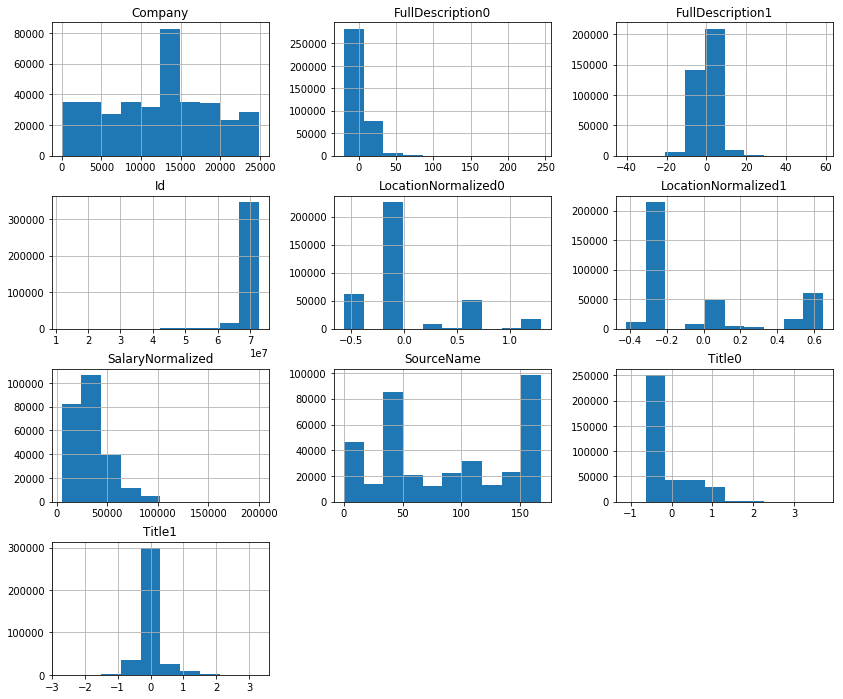

In [256]:
df.hist(figsize=(14, 12))

### Separando Train e Test 

In [257]:
del df['Id']
del df['SalaryNormalized']

In [258]:
df.head()

,Company,SourceName,LocationNormalized0,LocationNormalized1,Title0,Title1,FullDescription0,FullDescription1
0,9229,42,-0.116790,-0.229172,-0.211709,0.010168,-18.530014,2.881801
1,9229,42,-0.118995,-0.237572,-0.379568,-0.578663,1.115408,-2.899837
2,9229,42,-0.120516,-0.241914,-0.204017,0.064045,-1.111251,2.198475
3,9229,42,-0.122604,-0.249312,-0.211709,0.010168,-18.890457,3.393423
4,9229,42,-0.122604,-0.249312,-0.211709,0.010168,-19.451188,2.751042


In [259]:
X_train = df.values[:df_job_tuple[0], :df_job_tuple[0]]

In [260]:
X_test = df.values[:df_test_tuple[0], :df_test_tuple[0]]

In [261]:
X_train.shape, X_test.shape

((244766, 8), (122463, 8))

### Criando Scaler

In [263]:
scaler = StandardScaler()

### Criando Folds

In [264]:
n_splits = 10
kfold = KFold(n_splits=n_splits)

### Função para executar modelos

In [265]:
def cross_validation(model, X, y):
    scoring = [ 'neg_mean_absolute_error', 'neg_mean_squared_error']
    pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
    
    return cross_validate(pipeline, X=X, y=y, cv=kfold, n_jobs=1, verbose=5, scoring=scoring, return_train_score=True)

## Criando modelos

In [266]:
rf_model = RandomForestRegressor(n_estimators=50, min_samples_split=30, random_state=1)

In [267]:
gb_model = GradientBoostingRegressor(min_samples_split=30, random_state=1)

In [268]:
ada_model = AdaBoostRegressor(random_state=1)

In [269]:
knn_model = KNeighborsRegressor()

## Treinamento

In [270]:
def calc_metrics(cv):
    '''Retorna as tuplas contendo (rmse_train, rmse_test) , (mae_train, mae_test)'''
    time_train = np.sum(cv['fit_time']) / n_splits
    print('Tempo médio de treinamento: %f seg. Para 1 / %d folds' % (time_train, n_splits))
    train_rmse = np.sum(np.sqrt(np.abs(cv['train_neg_mean_squared_error']))) / n_splits
    print('RMSE Train: %.2f' % train_rmse)
    test_rmse = np.sum(np.sqrt(np.abs(cv['test_neg_mean_squared_error']))) / n_splits
    print('RMSE Test: %.2f' % test_rmse)
    mae_train = np.sum(np.abs(cv['train_neg_mean_squared_error'])) / n_splits
    print('MAE Train: %.2f' % mae_train)
    mae_test = np.sum(np.abs(cv['test_neg_mean_squared_error'])) / n_splits
    print('MAE Test: %.2f' % mae_test)
    return (train_rmse, test_rmse) , (mae_train, mae_test)

### KNN

In [271]:
cv_knn = cross_validation(model=knn_model, X=X_train, y=y)
cv_knn

[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-12685.973305552152, neg_mean_squared_error=-304122865.90516645, total=  11.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-13356.993520447766, neg_mean_squared_error=-325638520.3811414, total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-13712.026449319768, neg_mean_squared_error=-320672771.6496646, total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-13522.491236671161, neg_mean_squared_error=-325192332.7262622, total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.4min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-13496.07007394697, neg_mean_squared_error=-325081517.22830087, total=   9.4s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-13322.775740491072, neg_mean_squared_error=-325439213.57288396, total=   9.1s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-13444.718589638831, neg_mean_squared_error=-330733038.4749485, total=   9.4s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-13544.787800294167, neg_mean_squared_error=-335721280.6270453, total=   9.2s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-13538.33361660402, neg_mean_squared_error=-325569272.2439647, total=   8.8s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-13588.120166693907, neg_mean_squared_error=-331692605.1628795,

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 13.2min finished


{'fit_time': array([0.93913698, 0.95052528, 0.84312224, 0.82429481, 0.79533362,
        0.80535126, 0.97619629, 0.81978226, 0.80367112, 0.82421613]),
 'score_time': array([10.03360677,  8.97757196,  7.5689044 ,  8.57959175,  8.64531207,
         8.25824142,  8.41873646,  8.33647299,  7.96712136,  8.70186543]),
 'test_neg_mean_absolute_error': array([-12685.97330555, -13356.99352045, -13712.02644932, -13522.49123667,
        -13496.07007395, -13322.77574049, -13444.71858964, -13544.78780029,
        -13538.3336166 , -13588.12016669]),
 'train_neg_mean_absolute_error': array([-10891.56388472, -10806.09391027, -10788.03617521, -10809.45374848,
        -10802.44566728, -10824.32854931, -10805.95799174, -10783.61143039,
        -10805.23312543, -10775.263036  ]),
 'test_neg_mean_squared_error': array([-3.04122866e+08, -3.25638520e+08, -3.20672772e+08, -3.25192333e+08,
        -3.25081517e+08, -3.25439214e+08, -3.30733038e+08, -3.35721281e+08,
        -3.25569272e+08, -3.31692605e+08]),
 'tr

In [272]:
knn_rmse, knn_mae = calc_metrics(cv_knn)

Tempo médio de treinamento: 0.858163 seg. Para 1 / 10 folds
RMSE Train: 14576.59
RMSE Test: 18025.97
MAE Train: 212477466.91
MAE Test: 324986341.80


### ADA

In [273]:
cv_ada = cross_validation(model=ada_model, X=X_train, y=y)
cv_ada

[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-18026.59717156553, neg_mean_squared_error=-436203278.82177216, total=  10.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV]  , neg_mean_absolute_error=-14086.39406115166, neg_mean_squared_error=-303697370.69939584, total=   6.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.4s remaining:    0.0s


[CV]  , neg_mean_absolute_error=-14497.848275125934, neg_mean_squared_error=-305129969.17546636, total=   8.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.0s remaining:    0.0s


[CV]  , neg_mean_absolute_error=-16808.006081666368, neg_mean_squared_error=-390860148.630144, total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.8s remaining:    0.0s


[CV]  , neg_mean_absolute_error=-14068.020373887357, neg_mean_squared_error=-302624342.10342324, total=   6.9s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-14126.87077556214, neg_mean_squared_error=-306093109.0017542, total=   7.4s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-13732.683230498624, neg_mean_squared_error=-293095706.45876855, total=   7.5s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-14217.656180605974, neg_mean_squared_error=-312771073.1200797, total=   6.9s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-14173.262098189978, neg_mean_squared_error=-306589571.9856712, total=   7.4s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-14050.543581768403, neg_mean_squared_error=-304371643.7064010

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


{'fit_time': array([ 9.90668845,  6.45981526,  8.04847336, 10.13515735,  6.87510085,
         7.37868142,  7.44444728,  6.859236  ,  7.38190651,  5.6998508 ]),
 'score_time': array([0.0626862 , 0.03798509, 0.04893899, 0.06131077, 0.04354501,
        0.0439086 , 0.04419541, 0.04118729, 0.04363227, 0.03371882]),
 'test_neg_mean_absolute_error': array([-18026.59717157, -14086.39406115, -14497.84827513, -16808.00608167,
        -14068.02037389, -14126.87077556, -13732.6832305 , -14217.65618061,
        -14173.26209819, -14050.54358177]),
 'train_neg_mean_absolute_error': array([-16281.59898887, -14006.81536966, -14404.75011922, -16784.77793312,
        -14042.15380637, -14185.868585  , -13943.36532318, -14082.49068848,
        -14081.79809772, -13897.6004175 ]),
 'test_neg_mean_squared_error': array([-4.36203279e+08, -3.03697371e+08, -3.05129969e+08, -3.90860149e+08,
        -3.02624342e+08, -3.06093109e+08, -2.93095706e+08, -3.12771073e+08,
        -3.06589572e+08, -3.04371644e+08]),
 'tr

In [274]:
ada_rmse, ada_mae = calc_metrics(cv_ada)

Tempo médio de treinamento: 7.618936 seg. Para 1 / 10 folds
RMSE Train: 17820.08
RMSE Test: 18020.35
MAE Train: 318313492.77
MAE Test: 326143621.37


### Gradient Boosting

In [275]:
cv_gb = cross_validation(model=gb_model, X=X_train, y=y)
cv_gb

[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-11157.757141783874, neg_mean_squared_error=-236307514.546646, total=  27.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s remaining:    0.0s


[CV]  , neg_mean_absolute_error=-11794.54542317465, neg_mean_squared_error=-252768448.2961616, total=  27.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.7s remaining:    0.0s


[CV]  , neg_mean_absolute_error=-11974.000602985794, neg_mean_squared_error=-248563334.5069125, total=  27.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-11718.60288485207, neg_mean_squared_error=-249430319.5574618, total=  27.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-11680.106617317362, neg_mean_squared_error=-249995110.64746425, total=  27.7s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-11418.145479275334, neg_mean_squared_error=-244904057.39809507, total=  27.1s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-11568.160365604053, neg_mean_squared_error=-248934116.92652842, total=  27.1s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-11794.06479295684, neg_mean_squared_error=-256482078.08974105, total=  27.3s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-11780.26542657853, neg_mean_squared_error=-249402499.14327267, total=  27.2s
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-12171.39535453055, neg_mean_squared_error=-267072995.233218

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.7min finished


{'fit_time': array([27.61209464, 27.65011168, 27.2816534 , 27.59758711, 27.61559343,
        27.00480771, 27.07606125, 27.19110966, 27.1590209 , 26.84476233]),
 'score_time': array([0.06998491, 0.07221317, 0.0750978 , 0.07314777, 0.07354879,
        0.07360482, 0.07236648, 0.07219744, 0.07217264, 0.07455015]),
 'test_neg_mean_absolute_error': array([-11157.75714178, -11794.54542317, -11974.00060299, -11718.60288485,
        -11680.10661732, -11418.14547928, -11568.1603656 , -11794.06479296,
        -11780.26542658, -12171.39535453]),
 'train_neg_mean_absolute_error': array([-11722.73349644, -11628.15233363, -11615.83555431, -11668.20734179,
        -11658.00362845, -11690.10426759, -11671.62031954, -11645.17506191,
        -11630.84285931, -11582.4413844 ]),
 'test_neg_mean_squared_error': array([-2.36307515e+08, -2.52768448e+08, -2.48563335e+08, -2.49430320e+08,
        -2.49995111e+08, -2.44904057e+08, -2.48934117e+08, -2.56482078e+08,
        -2.49402499e+08, -2.67072995e+08]),
 'tr

In [276]:
gb_rmse, gb_mae = calc_metrics(cv_gb)

Tempo médio de treinamento: 27.303280 seg. Para 1 / 10 folds
RMSE Train: 15762.72
RMSE Test: 15821.84
MAE Train: 248464082.25
MAE Test: 250386047.43


### Random Forest

In [277]:
cv_rf = cross_validation(model=rf_model, X=X_train, y=y)
cv_rf

[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-10455.372119829986, neg_mean_squared_error=-217434181.2922031, total= 1.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-10928.521278788283, neg_mean_squared_error=-220613589.8554696, total= 1.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.7min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-11142.203312201136, neg_mean_squared_error=-222814795.3751126, total= 1.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.6min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-10898.332185039357, neg_mean_squared_error=-219861113.39863864, total= 1.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.4min remaining:    0.0s


[CV]  , neg_mean_absolute_error=-10757.151731450098, neg_mean_squared_error=-216575519.43371564, total= 1.7min
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-10533.368663378076, neg_mean_squared_error=-213042538.59741327, total= 1.8min
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-10782.932878683925, neg_mean_squared_error=-218226930.35436878, total= 1.8min
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-10895.059390163617, neg_mean_squared_error=-223279548.11551553, total= 1.7min
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-10771.6545234562, neg_mean_squared_error=-215919823.7076418, total= 1.7min
[CV]  ................................................................
[CV]  , neg_mean_absolute_error=-11297.096975680786, neg_mean_squared_error=-235400339.703825

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 18.4min finished


{'fit_time': array([103.4280529 , 106.41595149, 106.93811679, 105.83180761,
        104.17053199, 106.16159153, 108.26112056, 101.72895241,
        100.85266733, 100.95680785]),
 'score_time': array([0.60349679, 0.60762167, 0.62306309, 0.60878992, 0.64006448,
        0.68612719, 0.59401655, 0.6063838 , 0.59904742, 0.59874058]),
 'test_neg_mean_absolute_error': array([-10455.37211983, -10928.52127879, -11142.2033122 , -10898.33218504,
        -10757.15173145, -10533.36866338, -10782.93287868, -10895.05939016,
        -10771.65452346, -11297.09697568]),
 'train_neg_mean_absolute_error': array([-8369.41769811, -8320.75310612, -8326.0715284 , -8345.51824293,
        -8325.88116065, -8363.95158476, -8342.9088071 , -8324.69521833,
        -8343.51265885, -8257.02241748]),
 'test_neg_mean_squared_error': array([-2.17434181e+08, -2.20613590e+08, -2.22814795e+08, -2.19861113e+08,
        -2.16575519e+08, -2.13042539e+08, -2.18226930e+08, -2.23279548e+08,
        -2.15919824e+08, -2.35400340e+08

#### RMSE & MAE

In [278]:
rf_rmse, rf_mae = calc_metrics(cv_rf)

Tempo médio de treinamento: 104.474560 seg. Para 1 / 10 folds
RMSE Train: 11460.53
RMSE Test: 14841.79
MAE Train: 131344813.73
MAE Test: 220316837.98


## Visualização dos resultados

In [279]:
rmses = np.array([knn_rmse, ada_rmse, gb_rmse, rf_rmse])
rmses

array([[14576.5875465 , 18025.96891592],
       [17820.07682486, 18020.34891532],
       [15762.72186577, 15821.84438009],
       [11460.53036498, 14841.79143433]])

In [280]:
maes = np.array([knn_mae, ada_mae, gb_mae, rf_mae])
maes

array([[2.12477467e+08, 3.24986342e+08],
       [3.18313493e+08, 3.26143621e+08],
       [2.48464082e+08, 2.50386047e+08],
       [1.31344814e+08, 2.20316838e+08]])

### RMSE 

Text(0.5,1,'RMSE Train')

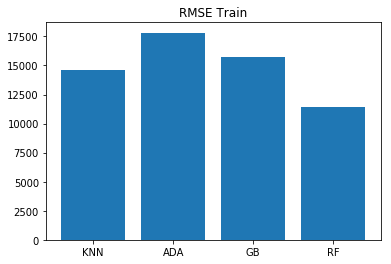

In [281]:
class_names = np.array(['KNN', 'ADA', 'GB', 'RF'])
plt.bar(range(rmses.shape[0]), rmses[:, 0])
plt.xticks(range(rmses.shape[0]), class_names)
plt.title('RMSE Train')

Text(0.5,1,'RMSE Test')

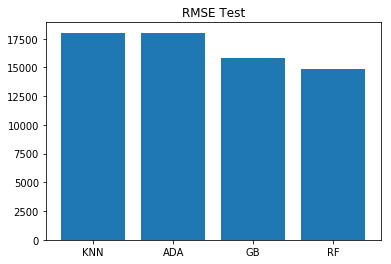

In [282]:
class_names = np.array(['KNN', 'ADA', 'GB', 'RF'])
plt.bar(range(rmses.shape[0]), rmses[:, 1])
plt.xticks(range(rmses.shape[0]), class_names)
plt.title('RMSE Test')

### MAE

Text(0.5,1,'MAE Train')

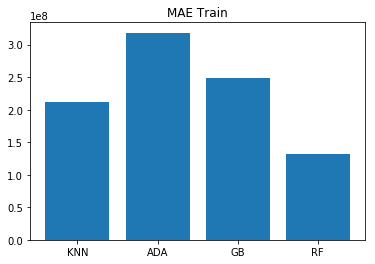

In [283]:
class_names = np.array(['KNN', 'ADA', 'GB', 'RF'])
plt.bar(range(maes.shape[0]), maes[:, 0])
plt.xticks(range(maes.shape[0]), class_names)
plt.title('MAE Train')

Text(0.5,1,'MAE Test')

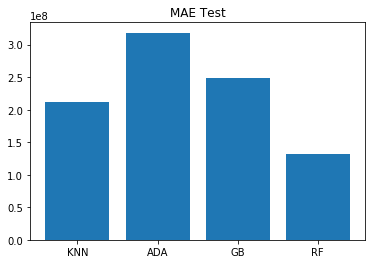

In [284]:
class_names = np.array(['KNN', 'ADA', 'GB', 'RF'])
plt.bar(range(maes.shape[0]), maes[:, 0])
plt.xticks(range(maes.shape[0]), class_names)
plt.title('MAE Test')

### Dificuldades

- Trabalhar com textos nas features
- Saber quando remover um label

### Aprendizados

- Utilização das ferramentas ja existentes para realizar atividades que seriam realizadas manualmente.
- Um pouco de conhecimento sobre como funciona uma predição baseada em textos.

### Possíveis melhorias futuras

O score que é retornada é, portanto, negativo quando o score deve ser minimizado e positivo se for um score que deva ser maximizado

Portanto, minizar o score é uma melhoria futura.